<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/2_feature_importance/2_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Feature importance - deciphering ML’s predictions

Tired of hearing people criticise ML algorithms for their black box nature? In this workshop we present three different ways to estimate the importance of the input features on the model outputs, enabling a better interpretation of our results: impurity feature importance, permutation feature importance and shap feature importance.

## 2.1 Setting up our RF model

### Model training and evaluation

To begin estimating feature importance we need a model. We will use the same model as in the previous [*Understanding Random Forest*](../1_understanding_random_forest.ipynb) workshop. Surprise, surprise, it's a Random Forest model. The task was to predict the water level at the Hagestein station using a selection of five meteorological and hydrological variables: the discharge of the Rhine and Meuse at the Dutch border, the water level of the North Sea, precipitation and evaporation. For more information about the data sources, we encourage you to check [Hauswirth et al. (2021)](https://doi.org/10.1016/j.advwatres.2021.104017).

The code blocks below (1) loads the data, (2) splits our data into training and testing datasets, (3) trains our random forest model and (4) provides a simple evaluation of the model performance. This time we import the libraries as we need them. If you have any problems understanding what is happening you can take a look at our previous workshops.

In [7]:
import pandas as pd

# Load the data
data_url =  "https://raw.githubusercontent.com/Jignesh1594/CodeGeoworkshop_02_understanding_RF/master/data.csv"
data = pd.read_csv(data_url, delimiter=",", on_bad_lines='skip')

# Select the input and output data
input_data = data[['WLHv', 'RH', 'EV24', 'QMeuse', 'QRhine']]
output_data = data['value']

# Display the first few rows of the data
input_data.join(output_data).head()

,WLHv,RH,EV24,QMeuse,QRhine,value
0,-18.395833,1.0,24.0,290.0,2579.0,269.72
1,-3.223881,177.0,23.0,167.0,1914.0,290.68
2,-13.020833,46.0,17.0,158.0,1864.0,289.52
3,2.618056,77.0,23.0,144.0,1777.0,287.88
4,5.812500,43.0,17.0,151.0,1759.0,290.92


In [2]:
import sklearn.model_selection as model_selection

# Split the data into training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(input_data,
                                                                    output_data, 
                                                                    test_size=0.1,
                                                                    shuffle=False)

print(f"Train sample size is {X_train.index.size} and test sample size is {X_test.index.size}")

Train sample size is 11894 and test sample size is 1322


In [6]:
import sklearn.ensemble as ensemble

# Train the model
model = ensemble.RandomForestRegressor(random_state=42)
model.fit(X_train, y_train);

Mean Squared Error: 283.86055858294


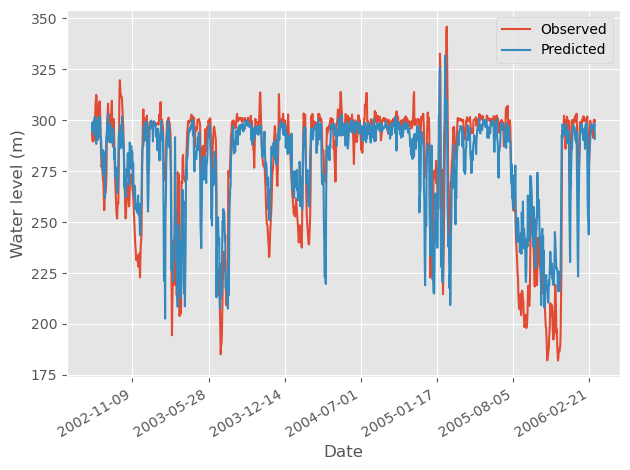

In [10]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates

# Set the style
style.use('ggplot')

# Evaluate the model MSE
y_pred = model.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

prediction = {"date": y_test.index,
              "Observed": y_test,
              "Predicted": y_pred}
prediction = pd.DataFrame(prediction)

# Plot the prediction
fig, ax = plt.subplots()
prediction.plot.line(x = "date", ax=ax)
ax.set_ylabel("Water level (m)")
ax.set_xlabel("Date")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
fig.tight_layout()

### Input features

It seems the model has a decent performance, but how is it doing those predictions? To that end we will investigate the importance of the input features for these prediction. Naturally, what is particularly important for this workshop is the input data for the Random Forest model. Here we use five inputs, called 'WLHv', 'RH', 'EV24', 'QMeuse', 'QRhine', that represent the north sea water level, rainfall, evaporation, discharge in the Meuse and discharge in the Rhine, respectively. The code below makes a quick plot of all the input data in the test dataset.

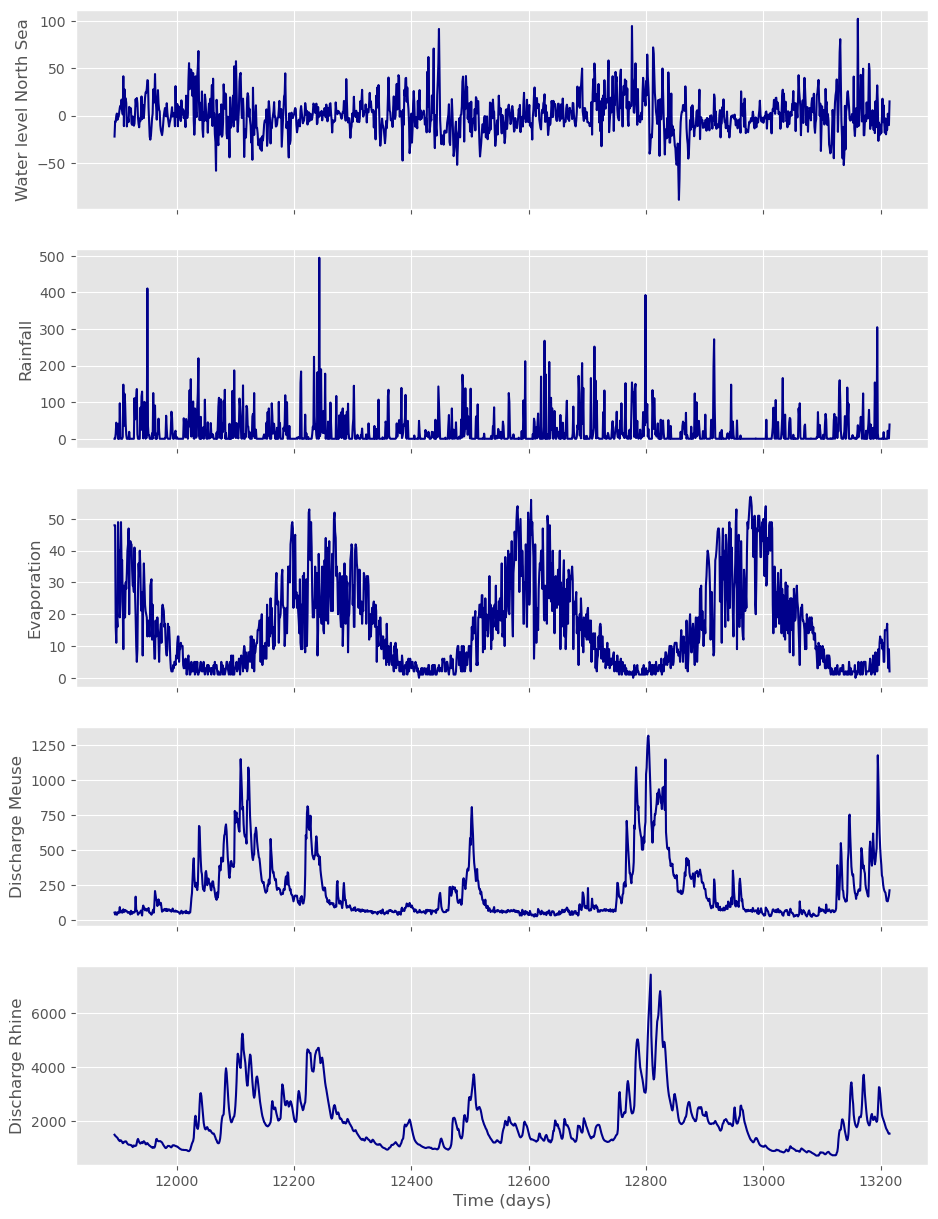

In [34]:
# Plot all columns of X_test
ax = X_test.plot(figsize=(11, len(X_test.columns)*3), color='darkblue',
                 y=['WLHv', 'RH', 'EV24', 'QMeuse',	'QRhine'],
                 subplots=True, sharex=True, xlabel="Time (days)", legend=False,)

# Add labels to the y-axes
ax[0].set_ylabel("Water level North Sea")
ax[1].set_ylabel("Rainfall")
ax[2].set_ylabel("Evaporation")
ax[3].set_ylabel("Discharge Meuse")
ax[4].set_ylabel("Discharge Rhine")

plt.show()

## 2.2 Impurity feature importance

### A bit of theory

Impurity feature importance is a special type of feature importance that is only available for random forest models and is sometimes called "gini importance" or "mean decrease impurity". This is the same as used in the previous workshop on [*Understanding Random Forests*](../1_understanding_random_forest.ipynb), but now we will try to understand it better. It is important to remember that random forests aggregate the results of multiple decision trees, which make their predictions by making binary decisions that split the data based on the input features.

Impurity feature importance measures how much each feature reduces the impurity in each of the decision tere nodes (or groups of data after a split). In regression tasks, impurity is often calculated as the variance of the output feature.

Here's how it works for a specific decision split:

1. When a node splits the data using a feature, creating two child nodes

2. The impurity (or variance in regression tasks) is calculated for the parent node.

3. The sum of the impurities (weighted by the proportion of samples) is calculated for the child nodes.

4. The impurity reduction is defined as the difference between 3. and 4.

The next step, is to sum all of the decreases in impurity in which a feature is involved for all the decision splits in all the trees. Those also need to be weighted by the proportion of samples reaching that specific node, so we account for the probability of reaching that node. We can then compare this score with the one obtained from other features to get a sense of which is more important, that is, most useful for improving prediction accuracy.

### Engage some braincells

Impurity feature importance is directly calculated by the sklearn package and stored in a property of the *RandomForestRegressor* class. Go to the [RandomForestRegressor documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), identify the property that stores the feature importance, and add it below by replacing `importance_property` in the first line. If today is not the day to engage your braincells, you can see the answer in the text below.

In [ ]:
# Obtain the feature importance
importances = model.importance_property # Replace with the correct property

# Visualize the results as a table
feature_importance = pd.DataFrame({"Feature": X_test.columns.to_list(),
                                   "Importance": importances.tolist()})
feature_importance

<details>
    <summary>Click to see the solution</summary>
    The feature importance property of the <i>RandomForestRegressor</i> class is <code>feature_importances_</code>
</details>

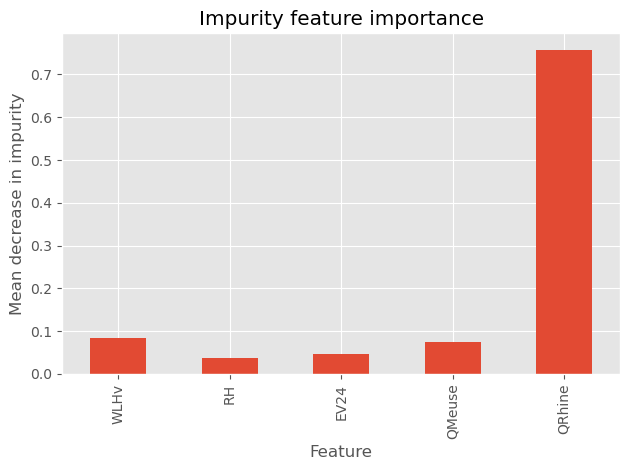

In [42]:
# Plot the feature importance
fig, ax = plt.subplots()
feature_importance.plot.bar(x = "Feature",
                            y = "Importance",
                            ax=ax, legend=False)
ax.set_title("Impurity feature importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

## 2.3 Permutation feature importance

### A bit of theory

Permutation feature importance is a more generalizable method that can be applied to any type of machine learning model (e.g. random forest, neural network, LSTM) to determine the feature importance. Permutation feature importance is defined as the decrease in a model score when a feature is changed in some way, that is by permuting them. The features are permuted one-at-a-time, keeping the rest the same. For each of the feature permutations, we predict the new model outputs and compare them the original model ones using some metric. The change in such metric is the score that we assign to each feature to compare their importance.

We will try four different types of changes in the variable features to assess their importance. The first three types perform a **single value** impact analysis by eliminating the signal of a specific input feature completely. This can be achieved by setting all of the feature values to the minimum, mean and maximum of its distribution. The fourth type is the proper **permutation** impact analysis, which aims to introduce a lot of noise to the signal of the input feature by shuffling the data points around.

### A practical example

To get an idea of how to do that in practice, let's see two of the examples mentioned before, the mean and permutation importances. Before we get to the importances themselves though, let's see how each of those change how an input variable looks, for example the discharge at the Rhine station.

We can use the pandas `mean` and `sample` methods to easily transform our data, and then plot it with *matplotlib* as usual.

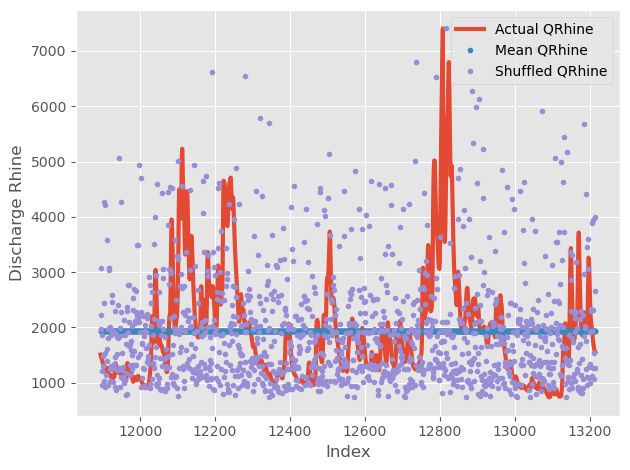

In [62]:
import numpy as np

# Get the test data for the QRhine feature
actual_QRhine = X_test['QRhine']

# Take the mean of the QRhine feature and create a series
mean_QRhine_value = actual_QRhine.mean()
mean_QRhine = pd.Series(mean_QRhine_value, index=actual_QRhine.index)


# Shuffle the QRhine feature (and its indices)
shuffled_QRhine = actual_QRhine.sample(frac=1, random_state=42)
shuffled_QRhine.index = np.random.permutation(shuffled_QRhine.index)

# Plot the actual, mean and shuffled QRhine features
fig, ax = plt.subplots()
actual_QRhine.plot(ax=ax, label="Actual QRhine", linewidth=3)
mean_QRhine.plot(ax=ax, label="Mean QRhine", style='.')
shuffled_QRhine.plot(ax=ax, label="Shuffled QRhine", style='.')
ax.set_ylabel("Discharge Rhine")
ax.set_xlabel("Index")
ax.legend()
fig.tight_layout()
plt.show()

Now we are going to assess the difference between the original model outputs and the permuted model outputs for the mean values, in this case using the mean squared error (MSE) metric.

In [64]:
import sklearn.metrics as metrics

mean_importance = {"feature": [],
                   "importance": [],}

for input_feature in X_test.columns:
    # Mean premutation importance:
    # Takes the input feature mean to determine performance
    X_test_permuted = X_test.copy()
    X_test_permuted[input_feature] = X_test_permuted[input_feature].mean()
    
    permutation = {"date": X_test.index,
                  "actual": X_test[input_feature],
                  "permuted": X_test_permuted[input_feature]}
    permutation = pd.DataFrame(permutation)
    
    # Register the feature importance
    y_pred_permuted = model.predict(X_test_permuted)
    mse_permuted = metrics.mean_squared_error(y_pred, y_pred_permuted)
    
    mean_importance["feature"].append(input_feature)
    mean_importance["importance"].append(mse_permuted)
    print(f'Permutation (mean) importance of {input_feature}: {mse_permuted}')
    

Permutation (mean) importance of WLHv: 21.707866650952177
Permutation (mean) importance of RH: 9.196770525048358
Permutation (mean) importance of EV24: 24.394988567747134
Permutation (mean) importance of QMeuse: 21.37974625210605
Permutation (mean) importance of QRhine: 908.4530449012992


### 2.3.1 Engaging some brain cells
Now that you have seen how to calculate the mean permutation feature importance, do the same for the minimum, maximum and shuffle feature importance in the three code blocks below. Just copy the above code and adjust where necessary. Make sure you register the importance information to the correct dictionary: *minimum_importance*, *maximum_importance* and *shuffle_importance* respectively. A quick tip is to take a look at the [DataFrame sample function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) for the shuffle importance. If today is not the day to engage your braincells, you can see the answer in the text below.

In [ ]:
minimum_importance = {"feature": [],
                   "importance": [],}

In [ ]:
maximum_importance = {"feature": [],
                   "importance": [],}

In [ ]:
shuffle_importance = {"feature": [],
                   "importance": [],}

<details>
  <summary>Click to see the minimum solution</summary>
  <pre><code class="language-python">
  import sklearn.metrics as metrics
  import matplotlib.pyplot as plt
  from matplotlib.style import use
  import matplotlib.dates as mdates

  minimum_importance = {"feature": [],
          "importance": [],}

  for input_feature in X_test.columns:
    X_test_permuted = X_test.copy()
    X_test_permuted[input_feature] = X_test_permuted[input_feature].min()
    
    permutation = {"date": X_test.index,
          "actual": X_test[input_feature],
          "permuted": X_test_permuted[input_feature]}
    permutation = pd.DataFrame(permutation)
    
    # Plot the permutation
    use('ggplot')
    fig, ax = plt.subplots()
    permutation.plot.line(x="date",
              ax=ax)
    ax.set_title("Actual vs Permuted")
    ax.set_ylabel(f"{input_feature}")
    ax.set_xlabel("Date")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.tight_layout()
    
    # Register the feature importance
    y_pred_permuted = model.predict(X_test_permuted)
    mse_permuted = metrics.mean_squared_error(y_pred, y_pred_permuted)
    
    minimum_importance["feature"].append(input_feature)
    minimum_importance["importance"].append(mse_permuted)
    print(f'Permutation (minimum) importance of {input_feature}: {mse_permuted}')
  </code></pre>
</details>

<details>
    <summary>Click to see the maximum solution</summary>
    <pre><code class="language-python">
    import sklearn.metrics as metrics
    import matplotlib.pyplot as plt
    from matplotlib.style import use
    import matplotlib.dates as mdates

    maximum_importance = {"feature": [],
                    "importance": [],}

    for input_feature in X_test.columns:
        X_test_permuted = X_test.copy()
        X_test_permuted[input_feature] = X_test_permuted[input_feature].max()
        
        permutation = {"date": X_test.index,
                    "actual": X_test[input_feature],
                    "permuted": X_test_permuted[input_feature]}
        permutation = pd.DataFrame(permutation)
        
        # Plot the permutation
        use('ggplot')
        fig, ax = plt.subplots()
        permutation.plot.line(x="date",
                            ax=ax)
        ax.set_title("Actual vs Permuted")
        ax.set_ylabel(f"{input_feature}")
        ax.set_xlabel("Date")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.tight_layout()
        
        # Register the feature importance
        y_pred_permuted = model.predict(X_test_permuted)
        mse_permuted = metrics.mean_squared_error(y_pred, y_pred_permuted)
        
        maximum_importance["feature"].append(input_feature)
        maximum_importance["importance"].append(mse_permuted)
        print(f'Permutation (maximum) importance of {input_feature}: {mse_permuted}')
    </code></pre>
</details>

<details>
    <summary>Click to see the shuffle solution</summary>
    <pre><code class="language-python">
    import sklearn.metrics as metrics
    import matplotlib.pyplot as plt
    from matplotlib.style import use
    import matplotlib.dates as mdates

    shuffle_importance = {"feature": [],
                    "importance": [],}

    for input_feature in X_test.columns:
        X_test_permuted = X_test.copy()
        X_test_permuted[input_feature] = X_test_permuted[input_feature].sample(frac = 1).values
        
        permutation = {"date": X_test.index,
                    "actual": X_test[input_feature],
                    "permuted": X_test_permuted[input_feature]}
        permutation = pd.DataFrame(permutation)
        
        # Plot the permutation
        use('ggplot')
        fig, ax = plt.subplots()
        permutation.plot.line(x="date",
                            ax=ax)
        ax.set_title("Actual vs Permuted")
        ax.set_ylabel(f"{input_feature}")
        ax.set_xlabel("Date")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.tight_layout()
        
        # Register the feature importance
        y_pred_permuted = model.predict(X_test_permuted)
        mse_permuted = metrics.mean_squared_error(y_pred, y_pred_permuted)
        
        shuffle_importance["feature"].append(input_feature)
        shuffle_importance["importance"].append(mse_permuted)
        print(f'Permutation (shuffle) importance of {input_feature}: {mse_permuted}')
    </code></pre>
</details>

### 2.3.2 Lets finally plot the importances

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.style import use

mean_importance = pd.DataFrame(mean_importance)
minimum_importance = pd.DataFrame(minimum_importance)
maximum_importance = pd.DataFrame(maximum_importance)
shuffle_importance = pd.DataFrame(shuffle_importance)

permutation_importance = mean_importance[['feature']]
permutation_importance["mean"] = mean_importance['importance']
permutation_importance["minimum"] = minimum_importance['importance']
permutation_importance["maximum"] = maximum_importance['importance']
permutation_importance["shuffle"] = shuffle_importance['importance']

# Plot the feature importance
use('ggplot')
fig, ax = plt.subplots()
permutation_importance.plot.bar(x="feature",
                                ax=ax)
ax.set_title("Permutation feature importance")
ax.set_ylabel("Mean squared error")
fig.tight_layout()

## 2.4 SHAP importance
Lastly we take a look at SHAP importance values. The SHAP (SHapley Additive exPlanations) package is a popular Python library used for interpreting the output of machine learning models. It provides a unified framework for explaining the predictions made by black-box models. SHAP values, in particular, quantify the contribution of each feature to the prediction made by the model. They provide a measure of feature importance and help in understanding the impact of individual features on the model's output.

Here we first need to install the SHAP package (especially on Google Colab) if it is not yet installed. Then we build a SHAP explainer and use our test dataset to generate the feature importance values. *Note this may take some time!* Afterwards, we plot the feature importance of our model using the SHAP build-in features plotting functions [beeswarm](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html) and [bar](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html).

In [ ]:
%pip install shap

In [ ]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap_values

In [ ]:
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

### 2.4.1 Engage some braincells
SHAP also provides functionality to plot the *attribution* (both positive and negative) of the input features *for ever single prediction our model has made* using the [waterfall](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html). Look at the documentation and figure out how to make a waterfall plot for the 105th date in the code block below. If today is not the day to engage your braincells, you can see the answer in the text below.

<details>
    <summary>Click to see the solution</summary>
    ```python
    date_index = 105
    shap.plots.waterfall(shap_values[date_index])
    ```
</details>